Import statements

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, CuDNNLSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import initializers as init

# from tensorflow.keras.backend import set_session
import keras.backend as K
import nltk
import string
import numpy as np
import pandas as pd
import re
from tqdm import tqdm


methods to convert the target values into 2 classes, and preprocess the text inputs

In [0]:
def binary(y):
  if y>=0.5:
      return 1
  else:
      return 0
def preprocess(text):
  text = re.sub(r'\W+',' ',text.lower())
  return text
  

Drive mount while using Colab. not necessary otherwise

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


defining the path for the data 

In [0]:
datapath = 'gdrive/My Drive/data/'

Reading the data into a data frame

In [0]:
df = pd.read_csv(datapath+'ml/train.csv')



In [6]:
df.shape

(1804874, 45)

Appplying preprocessing on text and targets

In [0]:
x = df['comment_text'].apply(preprocess)
y = df['target'].apply(binary)

In [8]:
print(x.head())
print(y.head())
print(len(x),len(y))

0    this is so cool it s like would you want your ...
1    thank you this would make my life a lot less a...
2    this is such an urgent design problem kudos to...
3    is this something i ll be able to install on m...
4                 haha you guys are a bunch of losers 
Name: comment_text, dtype: object
0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int64
1804874 1804874


Inititalizing and fitting Keras tokenizer

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [0]:
vocabulary_size = len(tokenizer.word_index)+1


In [11]:
print(vocabulary_size)

309012


Padding the text inputs to a maximum length, and coverting them into sequences

In [12]:
MAX_LEN=150
sequences = tokenizer.texts_to_sequences(x)
tr_data = pad_sequences(sequences, maxlen=MAX_LEN)

print(len(tr_data))


1804874


Loading the pretraine GloVe embeddings

In [13]:
f = open(datapath+'glove.6B.300d.txt')
embedding_values = {}
for line in tqdm(f):
  value = line.split(' ')
  word = value[0]
  coef = np.array(value[1:],dtype = 'float32')
  embedding_values[word]=coef

400000it [00:28, 14198.81it/s]


Creating an embedding matrix for the Embedding Layer of the model.

In [14]:
embedding_matrix = np.zeros((vocabulary_size,300))
for word,i in tqdm(tokenizer.word_index.items()):
  values = embedding_values.get(word)
  if values is not None:
    embedding_matrix[i] = values

100%|██████████| 309011/309011 [00:00<00:00, 571972.93it/s]


In [0]:
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# set_session(tf.Session(config=config))

Splitting data into train and test datasets

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(tr_data,y,test_size = 0.25,random_state = 42)

In [0]:
# del x,y,tr_data

Method for setting keras session and setting seeds for all random methods that could be used in the model

In [0]:
import numpy as np
import tensorflow as tf
import random as rn
import os
from numpy.random import seed
from tensorflow import set_random_seed

def session_refresh():
  seed(2)
  set_random_seed(2)
  rn.seed(2)
  os.environ['PYTHONHASHSEED'] = '0'
  session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  K.set_session(sess)
  print('refreshed session')

Creating the initializers for Embedding Layer weights, all Hidden Kernels' weights, and Recurrent kernels' weights 

In [0]:
embeddingInit = init.RandomUniform(seed=2)
kernelInit = init.glorot_uniform(seed=2)
recurrentInit = init.Orthogonal(seed=2)

Creating the model, setting all parameters, adding checkpoints to save the model at it's best validation accuracy. And, finally training the model.

In [20]:
session_refresh()
# K.clear_session()
model = Sequential()
model.add(Embedding(vocabulary_size,300, input_length = MAX_LEN,weights = [embedding_matrix],trainable = False, embeddings_initializer=embeddingInit))
# model.add(Embedding(vocabulary_size, 145, input_length=145))
# model.add(Bidirectional(LSTM(145, dropout=0.2, recurrent_dropout=0.2,return_sequences=True),merge_mode='ave'))
# model.add(Bidirectional(LSTM(145, dropout=0.2, recurrent_dropout=0.2),merge_mode='ave'))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True,kernel_initializer=kernelInit,recurrent_initializer=recurrentInit)))#,merge_mode='ave'
model.add(Dropout(0.2,seed=2))
model.add(Bidirectional(CuDNNLSTM(100,kernel_initializer=kernelInit,recurrent_initializer=recurrentInit)))
model.add(Dropout(0.2,seed=2))
model.add(Dense(64,activation = 'relu',kernel_initializer=kernelInit))
model.add(Dense(1, activation='sigmoid',kernel_initializer=kernelInit))
adg = optimizers.Adagrad(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])#'adam'

filepath=datapath+'ml/models/'+"tox-ada-relu-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.summary()
# model.fit(tr_data, y, validation_split=0.25, epochs=3,batch_size=128)
history=model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=4,callbacks=callbacks_list,batch_size=500)

refreshed session
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          92703600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          321600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               241600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
den

Saving the model structure as json.

In [0]:
model_json = model.to_json()
with open(datapath+"ml/models/tox-ada-relu-model.json", "w") as json_file:
    json_file.write(model_json)

Plotting the model accuracy and model loss on train and validation datasets.

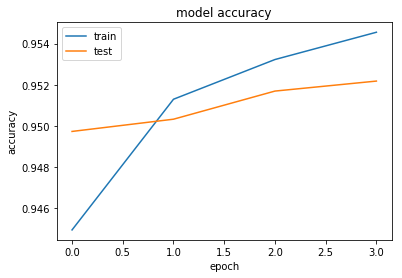

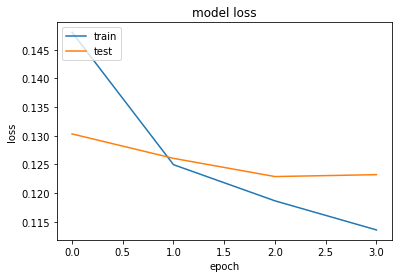

In [24]:
# print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Plotting the ROC curve on the Validation dataset

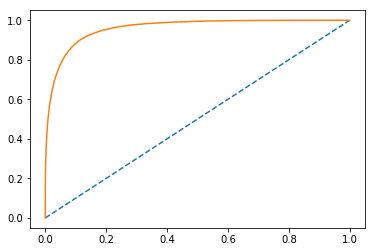

In [27]:
probs = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.show()

In [34]:
print(thresholds)

[1.9998909e+00 9.9989092e-01 9.9987793e-01 ... 5.7518482e-06 5.6922436e-06
 2.0265579e-06]


Preparing the unseen prediction dataset.

In [0]:
newtest= pd.read_csv(datapath+'ml/test.csv')
xt = newtest['comment_text'].apply(preprocess)
sequences = tokenizer.texts_to_sequences(xt)
ts_data = pad_sequences(sequences, maxlen=MAX_LEN)

Predicting the toxicity for the unseen dataset.

In [0]:
yts= model.predict(ts_data)

In [0]:
netdata = pd.DataFrame([newtest['id']]).T


In [0]:
netdata['prediction'] = yts

Saving the unseen test predictions into a fine

In [32]:
newtest['prediction'] = yts
newtest.head()

,id,comment_text,prediction
0,7000000,Jeff Sessions is another one of Trump's Orwell...,0.000910
1,7000001,I actually inspected the infrastructure on Gra...,0.000028
2,7000002,No it won't . That's just wishful thinking on ...,0.003245
3,7000003,Instead of wringing our hands and nibbling the...,0.002764
4,7000004,how many of you commenters have garbage piled ...,0.992859


In [0]:
newtest.to_csv('newdata.csv', index=False)